Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


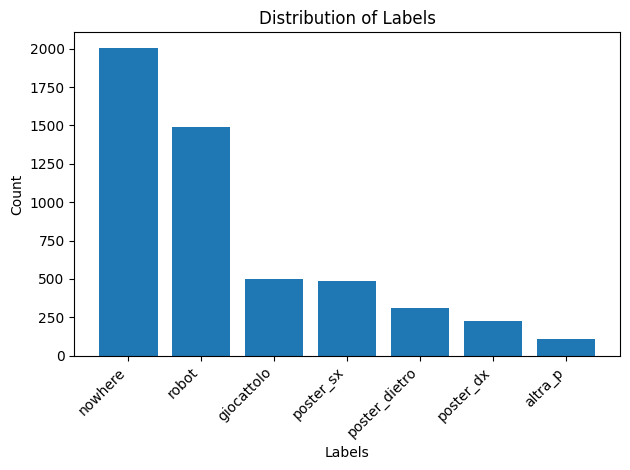

['robot', 'nowhere', 'poster_dietro', 'poster_sx', 'giocattolo', 'poster_dx', 'altra_p']
      confidence_azimuth  confidence_elevation  azimuth  elevation  bbox_x1  \
0                  0.125                 0.125    0.899     -0.352      637   
1                  0.179                 0.179   -0.733     -0.095      463   
2                  0.199                 0.199    0.895     -0.264      637   
3                  0.193                 0.193   -0.521     -0.076      464   
4                  0.139                 0.139    0.987     -0.223      637   
...                  ...                   ...      ...        ...      ...   
5117               0.148                 0.148   -0.593     -0.373      466   
5118               0.069                 0.069   -0.421     -0.246      632   
5119               0.077                 0.077   -0.488     -0.236      466   
5120               0.062                 0.062   -0.451     -0.254      632   
5121               0.061                 0

In [ ]:
# The same code will be used to preprocess test, inside the model itself
import pandas as pd
import matplotlib.pyplot as plt
import os

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

base_directory = '/content/drive/MyDrive/Colab Notebooks/PatientTrainigData'

# Change if needed
df = pd.read_csv(os.path.join(base_directory, 'training_set.csv'))

# Keep only relevant columns
columns_to_keep = ['confidence_azimuth', 'confidence_elevation', 'azimuth',
                   'elevation', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2',
                   'eyes_x', 'eyes_y', 'use_robot', 'label', 'patient', 'person_id']

# Assuming 'df' is your DataFrame and 'label' is the column containing labels
label_counts = df['label'].value_counts()

# Create a bar plot (histogram)
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Extract labels
output_names = df['label'].unique().tolist()

df = df[columns_to_keep]

# One-hot encoding for 'label'
# Numerical representation for 'use_robot'
df = pd.get_dummies(df, columns=['label'], prefix=['label'])
df['use_robot'] = df['use_robot'].map({'WR': 1, 'R': 0})
df['person_id'] = df['person_id'].map({'P' : 1, 'T': 0})

# Show what we load :)
print(output_names)
print(df)


The best acc is 40% - overfitted to one class, cannot get any meaningful acc with dataset this small

Training set size: 2949
Test set size: 1702
Validation set size: 471


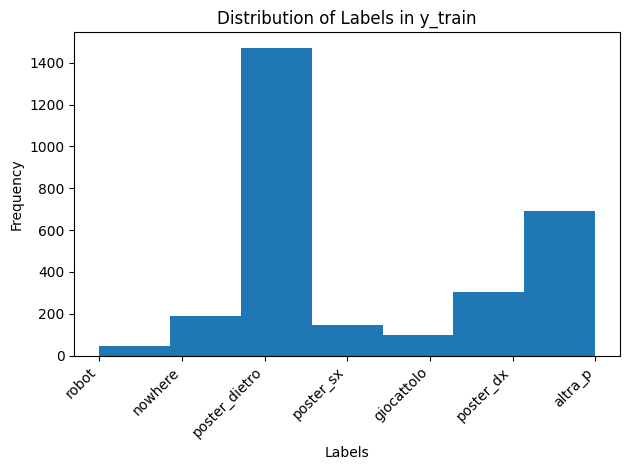

In [ ]:
# Devide dataset: training test validation roughly 60 30 10 [%]
# All data from one patient must go in the same group to avoid overfitting

from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.4, n_splits=1, random_state=42)
train_inds, test_val_inds = next(splitter.split(df, groups=df['patient']))

df_train = df.iloc[train_inds]
df_test_val = df.iloc[test_val_inds]

splitter2 = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42) # 0.25 x 0.3 = 0.1
test_inds, val_inds = next(splitter2.split(df_test_val, groups=df_test_val['patient']))

df_test = df_test_val.iloc[test_inds]
df_val = df_test_val.iloc[val_inds]

print("Training set size:", len(df_train))
print("Test set size:", len(df_test))
print("Validation set size:", len(df_val))

# Remove 'patient' column to prevent using it as a feature
X_train = df_train.drop(columns=['patient'])
X_test = df_test.drop(columns=['patient'])
X_val = df_val.drop(columns=['patient'])

# Separate features and labels
y_train = X_train.filter(like='label_').values.argmax(axis=1)
import matplotlib.pyplot as plt

# Assuming y_train is your NumPy array containing labels
plt.hist(y_train, bins=len(output_names))  # Set bins to the number of unique labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in y_train')
plt.xticks(range(len(output_names)), output_names, rotation=45, ha='right')  # Set x-axis ticks to label names
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

So intential overfitting was done to try cover a bigger portion of state space

Training set size: 3585
Test set size: 768
Validation set size: 769


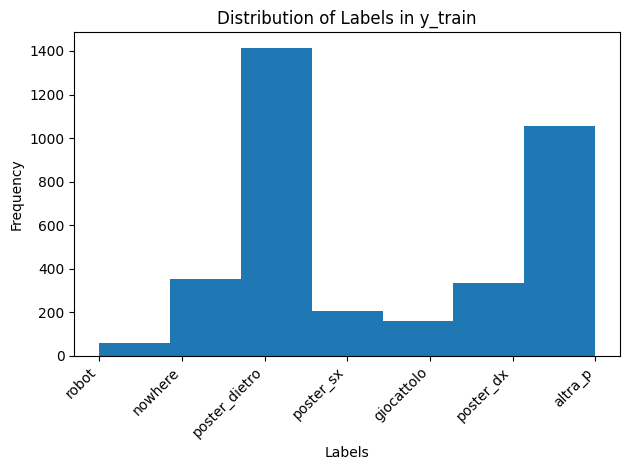

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test+val (70% train, 30% test+val)
df_train, df_test_val = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

# Split test+val into test and val (50% test, 50% val)
df_test, df_val = train_test_split(df_test_val, test_size=0.5, random_state=42)

print("Training set size:", len(df_train))
print("Test set size:", len(df_test))
print("Validation set size:", len(df_val))

# Remove 'patient' column to prevent using it as a feature
X_train = df_train.drop(columns=['patient'])
X_test = df_test.drop(columns=['patient'])
X_val = df_val.drop(columns=['patient'])

# Separate features and labels
y_train = X_train.filter(like='label_').values.argmax(axis=1)
import matplotlib.pyplot as plt

# Assuming y_train is your NumPy array containing labels
plt.hist(y_train, bins=len(output_names))  # Set bins to the number of unique labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in y_train')
plt.xticks(range(len(output_names)), output_names, rotation=45, ha='right')  # Set x-axis ticks to label names
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Remove 'patient' column to prevent using it as a feature
X_train = df_train.drop(columns=['patient'])
X_test = df_test.drop(columns=['patient'])
X_val = df_val.drop(columns=['patient'])

# Separate features and labels
y_train = X_train.filter(like='label_').values.argmax(axis=1)
y_test = X_test.filter(like='label_').values.argmax(axis=1)
y_val = X_val.filter(like='label_').values.argmax(axis=1)

X_train = X_train.drop(columns=X_train.filter(like='label_').columns)
X_test = X_test.drop(columns=X_test.filter(like='label_').columns)
X_val = X_val.drop(columns=X_val.filter(like='label_').columns)

# Normalize the data using only training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

Class Weights: {0: 8.535714285714286, 1: 1.4549512987012987, 2: 0.3619384149419485, 3: 2.4982578397212545, 4: 3.200892857142857, 5: 1.524234693877551, 6: 0.4845249358021354}


Decision Tree Accuracy: 0.5299479166666666
               precision    recall  f1-score   support

        robot       0.00      0.00      0.00        21
      nowhere       0.22      0.25      0.23        71
poster_dietro       0.67      0.70      0.68       292
    poster_sx       0.29      0.27      0.28        52
   giocattolo       0.28      0.32      0.30        34
    poster_dx       0.49      0.50      0.50        68
      altra_p       0.60      0.54      0.57       230

     accuracy                           0.53       768
    macro avg       0.36      0.37      0.37       768
 weighted avg       0.53      0.53      0.53       768



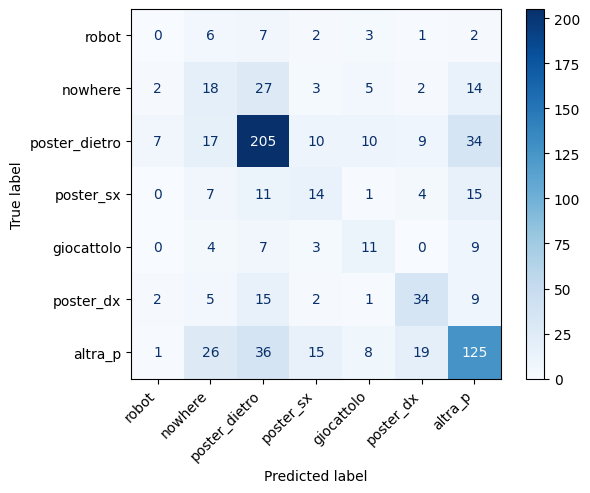

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create Decision Tree Classifier model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=output_names))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=output_names, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.show()


Random Forest Accuracy: 0.65234375
               precision    recall  f1-score   support

        robot       0.50      0.05      0.09        21
      nowhere       0.49      0.34      0.40        71
poster_dietro       0.72      0.83      0.77       292
    poster_sx       0.53      0.19      0.28        52
   giocattolo       0.75      0.26      0.39        34
    poster_dx       0.62      0.51      0.56        68
      altra_p       0.61      0.78      0.69       230

     accuracy                           0.65       768
    macro avg       0.60      0.42      0.45       768
 weighted avg       0.64      0.65      0.62       768



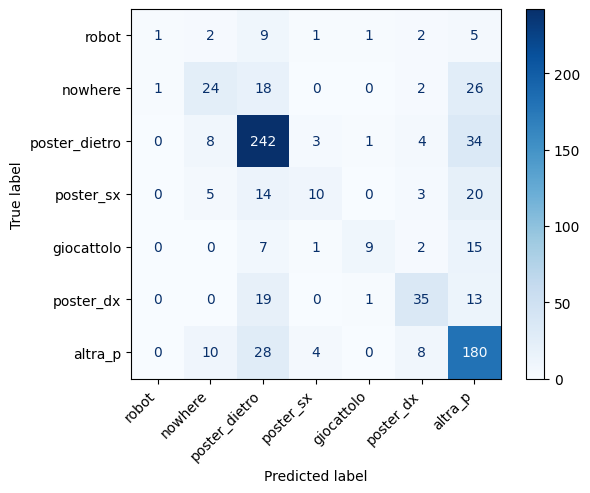

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=output_names))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=output_names, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# Define a function to create a model
def create_model(hidden_layers=2, hidden_units=64, dropout_rate=0.3, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_shape=(X_train.shape[1],)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(len(output_names), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Perform grid search for hyperparameters
from sklearn.model_selection import ParameterGrid

# Original grid we tested on, dropped: tanh (not good), small batch (data too noisy), lot of hidden units (data not that complex)
'''
grid = {
    'hidden_layers': [2, 3, 4],
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.3, 0.5],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64, 128],
    'epochs': [1000],
    'patience': [25]
}
'''
# Secondary grid: Bigger batch size preferable
'''
Training with parameters: {'activation': 'relu', 'batch_size': 256, 'dropout_rate': 0.5, 'epochs': 1000, 'hidden_layers': 3, 'hidden_units': 16, 'patience': 25}
0.40552017092704773
Training with parameters: {'activation': 'relu', 'batch_size': 256, 'dropout_rate': 0.5, 'epochs': 1000, 'hidden_layers': 3, 'hidden_units': 32, 'patience': 25}
0.4033970236778259
Training with parameters: {'activation': 'relu', 'batch_size': 128, 'dropout_rate': 0.5, 'epochs': 1000, 'hidden_layers': 5, 'hidden_units': 32, 'patience': 25}
0.40976646542549133
Training with parameters: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 1000, 'hidden_layers': 5, 'hidden_units': 8, 'patience': 25}
0.41401273012161255
Training with parameters: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 1000, 'hidden_layers': 5, 'hidden_units': 16, 'patience': 25}
0.40552017092704773
grid = {
    'hidden_layers': [2, 3, 4, 5],
    'hidden_units': [8, 16, 32],
    'dropout_rate': [0.5],
    'activation': ['relu'],
    'batch_size': [32, 64, 128, 256],
    'epochs': [1000],
    'patience': [25]
}
'''

#
grid = {
    'hidden_layers': [1,2,3],
    'hidden_units': [32, 64],
    'dropout_rate': [0.5],
    'activation': ['relu'],
    'batch_size': [64],
    'epochs': [200],
    'patience': [5]
}
param_grid = list(ParameterGrid(grid))
best_model = None
best_score = 0

for params in param_grid:
    print(f"Training with parameters: {params}")
    model = create_model(hidden_layers=params['hidden_layers'],
                         hidden_units=params['hidden_units'],
                         #dropout_rate=params['dropout_rate'],
                         activation=params['activation'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=params['patience'], restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=0,
                        class_weight=class_weights)

    val_acc = max(history.history['val_accuracy'])
    print(val_acc)
    if val_acc > best_score:
        best_score = val_acc
        best_model = model

Training with parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 200, 'hidden_layers': 1, 'hidden_units': 32, 'patience': 5}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0.37711313366889954
Training with parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 200, 'hidden_layers': 1, 'hidden_units': 64, 'patience': 5}
0.38491547107696533
Training with parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 200, 'hidden_layers': 2, 'hidden_units': 32, 'patience': 5}
0.38621586561203003
Training with parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 200, 'hidden_layers': 2, 'hidden_units': 64, 'patience': 5}
0.4239271879196167
Training with parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 200, 'hidden_layers': 3, 'hidden_units': 32, 'patience': 5}
0.3940182030200958
Training with parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 200, 'hidden_layers': 3, 'hidden_units': 64, 'patience': 5}
0.37711313366889954


Best validation accuracy: 0.4239271879196167
Evaluating on test set...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3654 - loss: 1.6275  
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report: ['robot', 'nowhere', 'poster_dietro', 'poster_sx', 'giocattolo', 'poster_dx', 'altra_p']
               precision    recall  f1-score   support

        robot       0.04      0.24      0.07        21
      nowhere       0.27      0.21      0.24        71
poster_dietro       0.75      0.51      0.61       292
    poster_sx       0.16      0.15      0.16        52
   giocattolo       0.13      0.21      0.16        34
    poster_dx       0.20      0.51      0.29        68
      altra_p       0.51      0.25      0.34       230

     accuracy                           0.36       768
    macro avg       0.29      0.30      0.26       768
 weighted avg       0.50      0.36      0.40       768

F1 Score: 0.39851717764972167


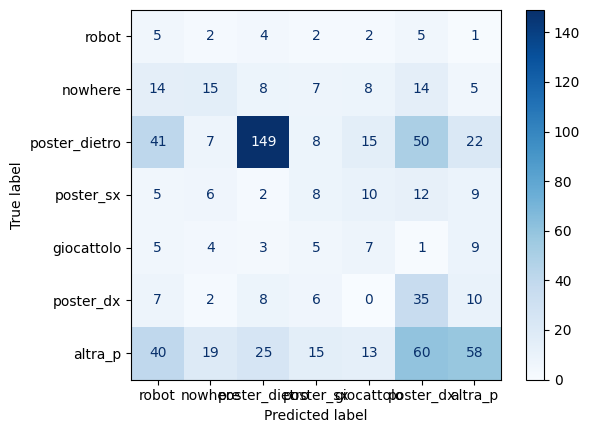

In [ ]:
# Depict best model
print(f"Best validation accuracy: {best_score}")

# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluate the model
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
y_pred = np.argmax(best_model.predict(X_test), axis=1)

print("Classification Report:", output_names)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=output_names))


# Display confusion matrix
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=output_names, cmap='Blues')

In order to show we understand we will take our best performing model :)

Depict Early stopping with Training.  

Give the final predictions for test.

XGBoost Accuracy: 0.6341145833333334
               precision    recall  f1-score   support

        robot       0.40      0.10      0.15        21
      nowhere       0.43      0.28      0.34        71
poster_dietro       0.73      0.83      0.78       292
    poster_sx       0.30      0.12      0.17        52
   giocattolo       0.57      0.24      0.33        34
    poster_dx       0.69      0.43      0.53        68
      altra_p       0.58      0.78      0.66       230

     accuracy                           0.63       768
    macro avg       0.53      0.39      0.42       768
 weighted avg       0.61      0.63      0.60       768



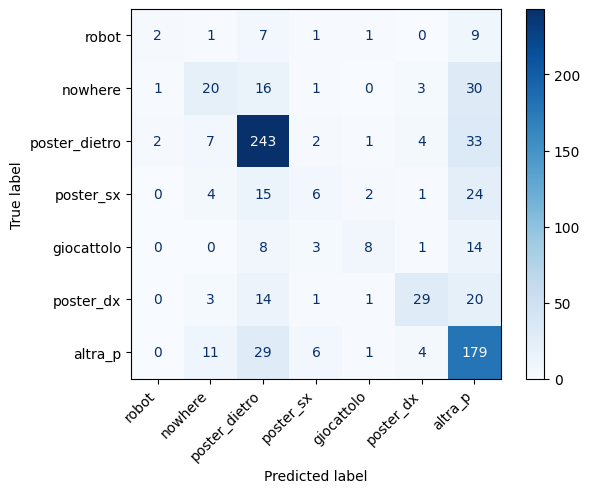

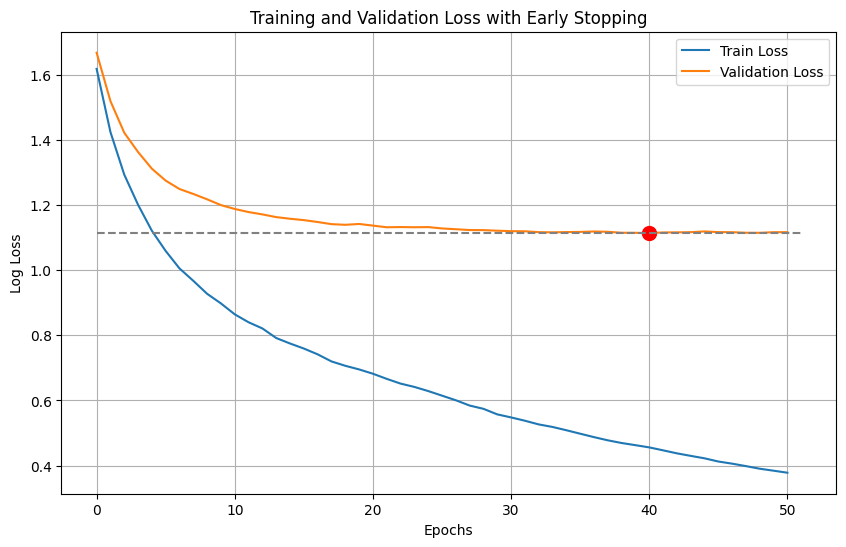

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]

# Create and train the XGBoost model with early stopping
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(output_names),
    early_stopping_rounds = 10,
    random_state=50,
    eval_metric='mlogloss'  # Monitoring log loss
)
xgb_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Get predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred, target_names=output_names))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=output_names, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.show()


# Retrieve evaluation results
results = xgb_model.evals_result()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.title('Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

# Find the minimum validation loss and corresponding epoch
min_val_loss = min(results['validation_1']['mlogloss'])
best_epoch = results['validation_1']['mlogloss'].index(min_val_loss)

# Add red circle and dashed horizontal line
plt.plot(best_epoch, min_val_loss, 'ro', markersize=10)  # Red circle
plt.hlines(min_val_loss, 0, len(results['validation_1']['mlogloss']), linestyles='dashed', colors='gray')

plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import pandas as pd

# Calculate additional evaluation metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Print out the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=output_names))

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred
})
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'")


Accuracy: 0.6341145833333334
Precision: 0.6096479884365903
Recall: 0.6341145833333334
F1 Score: 0.603575878073646
Classification Report:
               precision    recall  f1-score   support

        robot       0.40      0.10      0.15        21
      nowhere       0.43      0.28      0.34        71
poster_dietro       0.73      0.83      0.78       292
    poster_sx       0.30      0.12      0.17        52
   giocattolo       0.57      0.24      0.33        34
    poster_dx       0.69      0.43      0.53        68
      altra_p       0.58      0.78      0.66       230

     accuracy                           0.63       768
    macro avg       0.53      0.39      0.42       768
 weighted avg       0.61      0.63      0.60       768

Predictions saved to 'predictions.csv'
